<a href="https://colab.research.google.com/github/mavillot/Cell-Detection/blob/main/Notebooks/ZP_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An automatic model-based approach for measuring the Zona Pellucida (ZP) thickness in day five human blastocysts


> Yee, D., Saeedi, P., & Havelock, J. (2013). AN AUTOMATIC MODEL-BASED APPROACH FORMEASURING THE ZONA PELLUCIDA THICKNESS IN DAY FIVE HUMAN BLASTOCYSTS.

The proposed method consists in 5 sequential steps:
1. Create the initial circular model for blastocyst
2. Inner boundary ZP Detection
3. Outer Boundary ZP Detection
4. Refinement of boundaries detected
5. Verification of ellipse models

In this notebook we will be following the previous steps.


In [1]:
import cv2,os
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import imutils
from scipy import ndimage
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%%capture
!unzip Images.zip

In [4]:
files=['Images/'+ f for f in os.listdir('Images')]

# 1. Create Initial Circular Model for Blastocyst
Creation of a simple circular model to determine the center mass and the radius of the blastocyst.

#### 1.1. Edge detection with Canny

In [5]:
def canny_edges(img, u1=100,u2=150):
  # kernel = np.ones((5,5),np.float32)/25
  # dst = cv2.filter2D(img,-1,kernel)
  return cv2.Canny(img,u1,u2)

#### 1.2. Dilating the edges

In [6]:
def dilating(img,N=3): 
  return cv2.dilate(img, np.ones((N,N), np.uint8))

#### 1.3. Evaluating the convex hull of the connected edges

In [7]:
from skimage.morphology import convex_hull_image
def convex_hull_centerMass(dilate):
  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  perimeter=[]
  # edges:
  for c in cnts:
    perimeter.append(cv2.arcLength(c, True))
  # Calculate and get the largest edge
  i=perimeter.index(max(perimeter))
  contour=cv2.drawContours(cv2.cvtColor(np.zeros_like(dilate), cv2.COLOR_GRAY2BGR), cnts[i], -1, (0,255,0), 2)
  # Center mass of the largest edge
  M = cv2.moments(cnts[i])
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])
  return (convex_hull_image(cv2.cvtColor(contour, cv2.COLOR_BGR2GRAY)), (cX,cY))
  #return de convex hull and the center mass

#### 1.4. Calculate Sₚ (set of pixels along the perimeter). which is defined as it follows.

$$ Sₚ= \{pᵢ | pᵢ ∈ hull - eroded(hull)\} $$


In [8]:
def S_p(hull):
  mask=np.zeros(hull.shape,dtype=np.uint8)
  mask[hull==True]=255
  return mask-cv2.erode(mask,np.ones((3,3), np.uint8))

#### 1.5. Aproximation of the radius of the circle mask.

The radius is given by the average of all the radial distances form the points $(p_{i,x},p_{i,y}) \in S_p$  to the center mass $(x_c,y_c)$.

$$r=\frac{∑_{i}\sqrt{(p_{i,x}-x_c)^2 + (p_{i,y}-y_c)^2}}{|S_p|}$$

In [9]:
def radio(sp,cMass):
  Sp_points=[] #in this list we will save the points that are in the perimeter
  y,x=sp.shape
  for j in range(y):
    for i in range(x):
      if sp[j,i]==255: #Coordinates of the points that makes up the perimeter
        Sp_points.append(np.array((i,j)))
  # return the average distance between the center Mass and all the points of the perimeter
  return np.mean([np.linalg.norm(np.array(cMass) - p) for p in Sp_points])

#### 1.6. Construction of the circular model

In [10]:
def circle_mask(img,cMass,r):
  cX,cY=cMass
  mask=np.zeros(img.shape)
  try:
    return(cv2.circle(mask, cMass, round(r), (255,0,0), -1))
  except:
    # In case the radius or cMass is not well calculated
    return(np.ones(img.shape)*255)

#### Pipeline

In [11]:
def circularModel(gray,u1=70,u2=100):
  # step 1.1. & step 1.2. & step 1.3.:
  hull,cMass= convex_hull_centerMass(dilating(canny_edges(gray,u1,u2)))
  # step 1.4. & 1.5 & step 1.6.:
  return(circle_mask(gray,cMass,radio(S_p(hull), cMass)))

# 2. Inner Boundary ZP Deteccion
In this step, the inner boundary ZP is detected. 

The installation of the following library is needed in order to obtain the phase congruency of the image.

In [12]:
%%capture
!git clone https://github.com/alimuldal/phasepack.git
!python phasepack/setup.py install
!pip install pyfftw

In [13]:
import sys
sys.path.insert(1, 'phasepack')
from phasepack import phasecong

phasecong 
    Arguments:
    -----------
    <Name>      <Default>   <Description>
    img             N/A     The input image
    nscale          5       Number of wavelet scales, try values 3-6
    norient         6       Number of filter orientations.
    minWaveLength   3       Wavelength of smallest scale filter.
    mult            2.1     Scaling factor between successive filters.
    sigmaOnf        0.55    Ratio of the standard deviation of the Gaussian
                            describing the log Gabor filter's transfer function
                            in the frequency domain to the filter center
                            frequency.
    k               2.0     No. of standard deviations of the noise energy
                            beyond the mean at which we set the noise threshold
                            point. You may want to vary this up to a value of
                            10 or 20 for noisy images.
    cutOff          0.5     The fractional measure of frequency spread below
                            which phase congruency values get penalized.
    g               10      Controls the 'sharpness' of the transition in the
                            sigmoid function used to weight phase congruency
                            for frequency spread.
    noiseMethod     -1      Parameter specifies method used to determine
                            noise statistics.
                            -1 use median of smallest scale filter responses
                            -2 use mode of smallest scale filter responses
                            >=0 use this value as the fixed noise threshold

    Returns:
    ---------
    M       Maximum moment of phase congruency covariance, which can be used as
            a measure of edge strength
    m       Minimum moment of phase congruency covariance, which can be used as
            a measure of corner strength
    ori     Orientation image, in integer degrees (0-180), positive angles
            anti-clockwise.
    ft      Local weighted mean phase angle at every point in the image. A
            value of pi/2 corresponds to a bright line, 0 to a step and -pi/2
            to a dark line.
    PC      A list of phase congruency images (values between 0 and 1), one per
            orientation.
    EO      A list containing the complex-valued convolution results (see
            below)
    T       Calculated noise threshold (can be useful for diagnosing noise
            characteristics of images). Once you know this you can then specify
            fixed thresholds and save some computation time.


#### 2.1. Calculate the phase congruency in each orientation

#### 2.2. Thresholding each phase congruency image

PC images are float images with a small range of values. In order to threshold the image, an equalization of the image is needed.

In [14]:
# The next function transform float images into int images with values in between [0,255]
def equalize(img):
  m=max(img.flatten())
  img=img*255/m
  img=np.uint8(img)
  return img

In [15]:
#return a list of the 6 thresholded PC images
def thresh_pc(PC):
  thresh=[]
  for i in range(6):
    thresh.append(cv2.threshold(equalize(PC[i]),127,255,cv2.THRESH_BINARY)[1])
  return thresh

#### 2.3. Edge candidates
Considering the perimeter (not area) of the connected edge pieces in each orientation.

In [16]:
def inner_edge(thresh):
  for i in range(1,7):
    # we look for the connected edges:
    cnts,_ = cv2.findContours(thresh[i-1].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    perimeter=[]
    for c in cnts:
      # we calculate the perimeter and add it in the list
      perimeter.append(cv2.arcLength(c, True))
    # selecting the largest detected edges
    indices=[k for k in range(len(perimeter)) if perimeter[k]>50]
    # creation of image where we will draw the edges
    ctr=cv2.cvtColor(np.zeros_like(thresh[i-1]), cv2.COLOR_GRAY2BGR)
    for k in indices:
      # drawing the selected edges
      ctr=cv2.drawContours(ctr, cnts[k], -1, (0,255,0), 2)
    if i==1:
      edge=ctr
    else:
      edge=edge+ctr
  edge=edge[:,:,1]
  # thresholding the edge image
  return cv2.threshold(edge,127,255,cv2.THRESH_BINARY)[1]

#### 2.4. Invalidating edge candidates with the circular model (step 1) and convex hull
(*it invalidates far away candidates and candidates that do not coincide with the outer perimeter of the convex hull of all edges*)

In [17]:
from skimage.morphology import convex_hull_image
def final_edges(initial_mask,edge):
  # Invalidate far away candidates
  edge[initial_mask==0]=0
  # Calculate the convex hull of all the edges
  hull = convex_hull_image(edge)
  # Perimeter of the convex hull
  ctr=S_p(hull)
  # 
  EDGE_FINAL=np.zeros(ctr.shape)
  EDGE_FINAL[ctr==255]=edge[ctr==255]
  return(EDGE_FINAL)

#### 2.5. Fitting final edges with an ellipse

The first step is to obtain the coordinates of the points that made up the final edges.

In [18]:
# Given the edge return the coordinates of all the points that make up the edge
def coord(EDGE_FINAL):
  x_data,y_data=[],[]
  y,x=EDGE_FINAL.shape
  for i in range(y):
    for j in range(x):
      if EDGE_FINAL[i,j]==255:
        x_data.append(j)
        y_data.append(i)
  return (x_data, y_data)

Now, how do we find the ellipse that fit most of the points?

##### **Conic equation of an ellipse**

Considering the conic equation of an ellipse:
$$Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0$$
with $A>0$.

For estimating the coefficients of the ellipse we fix $F=-1$, so our **ellipse equation** is now transformed to:
$$Xβ=1$$

with $X=[x^2,xy,y^2,x,y]$ and $β=[A,B,C,D,E]^T$



##### **Estimation problem**



Let 

*   $\hat{β}$ denote the estimated vector of the parameters of $\beta$
*   $ Z=\begin{bmatrix}
      x_1^2 & x_1y_1 & y_1^2 & x_1 & y_1\\
      x_2^2 & x_2y_2 & y_2^2 & x_2 & y_2\\
      \vdots & & & & \\
      x_n^2 & x_ny_n & y_n^2  & x_n & y_n\\
\end{bmatrix} $ 
being $(x_i,y_i)$ the coordinates of the points from the final edge

* $y= \begin{bmatrix}
1 \\
1 \\
\vdots \\
1 \\
\end{bmatrix}$ with dimensions $(n$ x $1)$

To get our best estimated coefficients we need to solve the minimization problem by least square fitting.
$$\hat{β}= \textrm{argmin} \|y- Zβ\|^2$$
Solving the equation,
$$\hat{β}=(Z^TZ)^{-1}Z^Ty$$

In [19]:
# Given the coordinates of the ellipse (data) this function return the estimated coefficients A,B,C,D,E.
def estimated_coef(data):
  X=[]
  x_data,y_data=data
  for i in range(len(x_data)):
    x=x_data[i]
    y=y_data[i]
    X.append([x**2,x*y,y**2,x,y])
  X=np.array(X) 
  coef=np.linalg.lstsq(X, np.ones((len(x_data),1)))
  return(coef[0].flatten())

##### **Parametric equation**

To plot the ellipse, we need to get points that verify the equation. For that, we will use the polar coordinates.

If we consider the *canonical equation* of the ellipse, $(x_c,y_c)$ are determined by: 

$$x_c=a⋅ \cosα$$

$$y_c=b⋅ \sinα$$

with $\alpha ∈[0,2\pi]$


##### **Rotation**

However, if $B\neq 0$, our ellipse is rotated. Let $θ$ be the angle of rotation. The coordinates are determined by:

$$\begin{bmatrix}
x \\
y\\
\end{bmatrix} = \begin{bmatrix}
\cos θ &  - \sin θ\\
\sin θ &   \cos θ\\
\end{bmatrix} \cdot \begin{bmatrix}
x_c \\
y_c \\
\end{bmatrix}$$

\

$$x=a⋅ \cosα \ \cosθ - b⋅ \sinα \ \sinθ$$

$$y=a⋅ \cosα \ \sinθ + b⋅ \sinα \ \cosθ$$ 

##### **Translation**

Finally, if $x_0 \neq 0$ or $y_0 \neq 0$, our ellipse is translated with respect to the axis.

$$x=x_0 + a⋅ \cosα \ \cosθ - b⋅ \sinα \ \sinθ$$

$$y=y_0 + a⋅ \cosα \ \sinθ + b⋅ \sinα \ \cosθ$$ 

##### **Parameters**

$a,b,x_0,y_0$ and $θ$ are determined by the following formulas:
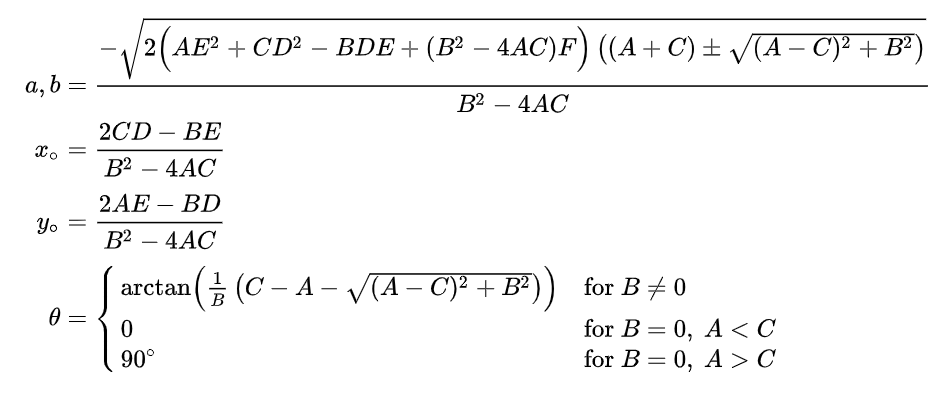

In [20]:
# Given the coeficients [A,B,C,D,E] returns a,b,x0,y0,theta
def parameters(coef): 
  s=np.sign(coef[0])
  A = coef[0]*s
  B = coef[1]*s
  C = coef[2]*s
  D = coef[3]*s
  E = coef[4]*s
  F = - 1.0 * s
  a = -np.sqrt(2*(A*E**2 + C*D**2 - B*D*E + (B**2 - 4*A*C)*F)*((A+C) + np.sqrt((A-C)**2+B**2)))/(B**2-4*A*C)
  b = -np.sqrt(2*(A*E**2 + C*D**2 - B*D*E + (B**2 - 4*A*C)*F)*((A+C) - np.sqrt((A-C)**2+B**2)))/(B**2-4*A*C)
  x0 = (2*C*D-B*E)/(B**2-4*A*C);
  y0 = (2*A*E-B*D)/(B**2-4*A*C);
  if B !=0:
    theta = np.arctan(1/B*(C-A-np.sqrt((A-C)**2+B**2)));
  else:
    if A<C:
      theta=0
    if A>C:
      theta=np.pi/2
  return(a,b,x0,y0,theta)

In [22]:
# Given a,b,x0,y0,theta, alpha returns the coordinates of the ellipse
def ellipse(a,b,x0,y0,theta,alpha = np.linspace(0,2*np.pi,100)):
  Xc =  a*np.cos(alpha);
  Yc =  b*np.sin(alpha);
  M = np.array([[np.cos(theta), -np.sin(theta)],[ np.sin(theta), np.cos(theta)]])
  T=np.dot(M,np.array([Xc,Yc]))
  if len(T.shape)>1:
    X=x0 +T[0,:]
    Y=y0 +T[1,:]
  else:
    X=x0 +T[0]
    Y=y0 +T[1]
  return(X,Y)

#### Pipeline

In [23]:
def inner_boundary(img, initial_mask):
  # step 1: calculate PC images in the 6 orientations
  _,_,_,_,PC,_,_=phasecong(img)
  # step 2: thresholding the 6 PC images
  thresh=thresh_pc(PC)
  # step 3: edge candidates
  edge=inner_edge(thresh)
  # step 4: invalidating far away candidates
  EDGE_FINAL=final_edges(initial_mask,edge)
  # step 5: ellipse
  a,b,x0,y0,theta=parameters(estimated_coef(coord(EDGE_FINAL)))
  # r_theta is the function that returns the coordinates in the angle alpha
  r_theta=lambda alpha: ellipse(a,b,x0,y0,theta,alpha-theta)
  return(ellipse(a,b,x0,y0,theta), (x0,y0) , r_theta)

In [24]:
# Given the coordinates of the constructed ellipse (X,Y) returns the mask of the ellipse
def MaskModel(img,X,Y):
  y,x=img.shape
  mask=np.zeros((y,x))
  for i in range(len(X)):
    x1,y1=round(X[i]),round(Y[i])
    if y1<y and x1<x and x1>0 and y1>0:
      mask[y1,x1]=255 
  mask=convex_hull_image(mask)
  mask_model=np.zeros(mask.shape,dtype='uint8')
  mask_model[mask]=255
  return mask_model

# 3. Outer Boundary ZP Detection

#### 3.1.Removing the image background T(I)

In [25]:
# Removes the background
def background(img):
  no_back=img- np.mean(img)
  no_back[no_back<0]=0
  return no_back

#### 3.2. Union of Canny edges on T(I) and thresholded phase congruency of I

In [26]:
def canny_pc(img):
  canny=canny_edges(equalize(background(img)),u1=100,u2=200)
  _,_,_,_,PC,_,_=phasecong(img,norient=1)
  pc=cv2.threshold(equalize(PC[0]),127,255,cv2.THRESH_BINARY)[1]
  return cv2.bitwise_or(pc,canny)

#### 3.3. Dilate mask and convex hull inner ZP

In [27]:
def convex_dilate(img,union, inner_mask):
  return 255-cv2.bitwise_or(dilating(union),inner_mask)

#### 3.4. Watershed segmentation

In [28]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.filters.rank.generic import threshold
from skimage import filters

In [29]:
def watershed_seg(img,union):
  dist_img=ndi.distance_transform_edt(union)
  local_max=peak_local_max(dist_img, indices=False, min_distance=3, labels=union)
  markers=ndi.label(local_max, structure=np.ones((3, 3)))[0]
  labels=watershed(-dist_img, markers, mask=union) 
  return cv2.watershed(cv2.cvtColor(equalize(img),cv2.COLOR_GRAY2RGB),markers)

#### 3.5. Remove regions of low intensity

In [30]:
def remove_low(img,markers,union):
  u=union.copy()
  media=np.mean(img)
  av=[np.mean(img[markers==l]) for l in np.unique(markers) if l!=-1 and l!=-2]
  for i in range(len(av)):
    if av[i]<media: 
      u[markers==i]=255
  # remove the edges of the watershed seg
  u[markers==-1]=255
  # remove regions that are inside the inner ellipse
  u[markers==-2]=255
  # remove all the labels from regions that are no longer candidates
  m=markers.copy()
  m[u==255]=-1
  return u,m

#### 3.6. Removing weak candidates

In [31]:
def remove_weak(img,union,markers,x0,y0,r_theta):
  r0=np.array((round(x0),round(y0)))
  a,b=0.4,0.5
  mean_img=np.mean(img)
  matrix, S = union==0, np.zeros(img.shape)
  y,x = matrix.shape
  for i in range(y):
    for j in range(x):
      if matrix[i,j]:
        x_= j - r0[0]
        y_= i - r0[1]
        d_s =np.sqrt(x_**2+y_**2)
        X ,Y = r_theta(np.arctan2(y_, x_))
        r= np.linalg.norm(r0-np.array((round(X),round(Y))))
        lbl=markers[i,j]
        mean_edge=np.mean(img[markers==lbl])
        if d_s < (1+a)*r and mean_edge > b*mean_img:
          S[i,j]=255  
  return S

#### Pipeline

In [32]:
def outer_boundary(img,inner_mask,x0,y0,r_theta):
  union=convex_dilate(img,canny_pc(img),inner_mask)
  markers=watershed_seg(img,union)
  markers[inner_mask==255]=-2
  union,markers=remove_low(img,markers,union)
  S=remove_weak(img,union,markers,x0,y0,r_theta)
  data=coord(S)
  a,b,x0,y0,t=parameters(estimated_coef(data))
  return ellipse(a,b,x0,y0,t)

# STEPS: 1,2 & 3

In [34]:
def ZPdetection(path):
  # Read the image
  img=cv2.imread(path)
  if len(img.shape)==3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  # Initial Model
  initial_mask=circularModel(img)
  # Inner ZP Model
  (X,Y),(x0,y0), r_theta=inner_boundary(img, initial_mask) 
  inner_mask=MaskModel(img,X,Y)
  # Outer ZP Model
  X,Y= outer_boundary(img,inner_mask,x0,y0,r_theta)
  out_mask= MaskModel(img,X,Y)
  return inner_mask,out_mask

In [35]:
start_time = time.time()
inner_mask,out_mask=ZPdetection(files[0])
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.300745010375977 seconds ---


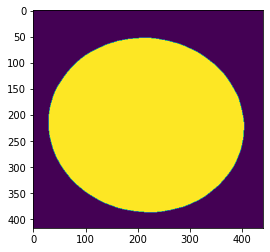

In [36]:
plt.imshow(inner_mask)

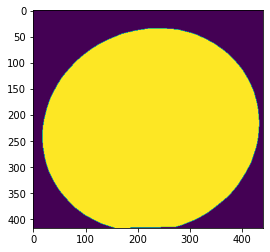

In [37]:
plt.imshow(out_mask)

# 5 & 4. Refinement

In [38]:
def tangencial_vector(a,b,x0,y0,theta, THETA= np.linspace(0,2*np.pi,100)):
  Xpc = - a*np.sin(THETA);
  Ypc =  b*np.cos(THETA);
  M = np.array([[np.cos(theta), -np.sin(theta)],[ np.sin(theta), np.cos(theta)]])
  Tp=np.dot(M,np.array([Xpc,Ypc]))
  if len(Tp.shape)>1:
    X=x0 +Tp[0,:]
    Y=y0 +Tp[1,:]
  else:
    X=x0 +Tp[0]
    Y=y0 +Tp[1]
  return (X,Y)

In [39]:
def verification(img, initial_mask):
  M,_,_,_,PC,_,_=phasecong(img)
  EDGE_FINAL=final_edges(initial_mask,inner_edge(thresh_pc(PC)))
  x_data,y_data=coord(EDGE_FINAL)

  _,th = cv2.threshold(equalize(M),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  th=dilating(th,N=3)
  for i in range(len(x_data)):
    # we do not consider edges that are not in M (Momentum strong edge)
    if th[y_data[i],x_data[i]]==0:
        EDGE_FINAL[y_data[i],x_data[i]]=0
  
  # building the ellipse
  a,b,x0,y0,theta=parameters(estimated_coef(coord(EDGE_FINAL)))
  X,Y=ellipse(a,b,x0,y0,theta)

  # GRADIENT IMAGE 
  sx = ndimage.sobel(img,axis=0,mode='constant')
  sy = ndimage.sobel(img,axis=1,mode='constant')

  verify=np.zeros(img.shape)

  for i in range(len(y_data)):
    # for each edge candidate we look for the nearest point in the ellipse
    x_= x_data[i] - x0
    y_= y_data[i] - y0

    # TANGENCIAL VECTOR
    Xp,Yp= tangencial_vector(a,b,x0,y0,theta, np.arctan2(y_, x_))
    tv=np.array([Xp,Yp])

    # GRADIENT VECTOR
    dx, dy=sx[y_data[i],x_data[i]],sy[y_data[i],x_data[i]]
    gv=np.array((dx,dy))

    # calculate the cos between the tangencial and gradient vector
    n=np.linalg.norm(tv)*np.linalg.norm(gv)
    cos=np.dot(tv,gv)/n
    if abs(cos)>1/np.sqrt(3):
      verify[y_data[i],x_data[i]]=255

  a,b,x0,y0,theta=parameters(estimated_coef(coord(verify)))
  r_theta=lambda THETA: ellipse(a,b,x0,y0,theta,THETA-theta)
  return(ellipse(a,b,x0,y0,theta), (x0,y0) , r_theta)

In [40]:
def ZPdetection(path):
  img=cv2.imread(path)
  if len(img.shape)==3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Initial Model
  initial_mask=circularModel(img)
  # Inner ZP Model
  (X,Y),(x0,y0), r_theta=verification(img, initial_mask) 
  inner_mask=MaskModel(img,X,Y)
  # Outer ZP Model
  X,Y= outer_boundary(img,inner_mask,x0,y0,r_theta)
  out_mask= MaskModel(img,X,Y)
  return inner_mask,out_mask

In [41]:
img=cv2.imread(files[0])
if len(img.shape)==3:
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
initial_mask=circularModel(img)
(X,Y),_,_=verification(img,initial_mask)
(X1,Y1),_,_=inner_boundary(img,initial_mask)

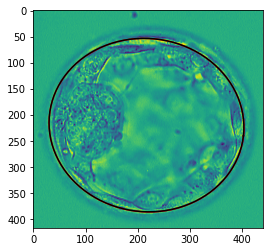

In [42]:
plt.imshow(img)
plt.plot(X,Y,'red')
plt.plot(X1,Y1,'black')

In [47]:
start_time = time.time()
inner_mask,out_mask=ZPdetection(files[0])
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.8731439113616943 seconds ---


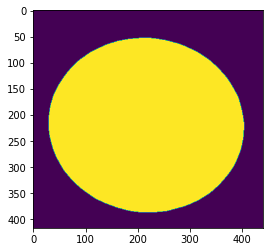

In [45]:
plt.imshow(inner_mask)

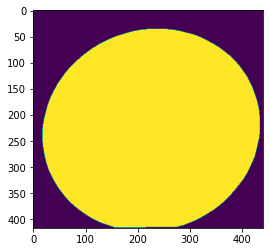

In [46]:
plt.imshow(out_mask)